### Importing libraries

In [1]:
%reset

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import json
import difflib
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances

### Preprocessing

In [5]:
dataset=pd.read_csv("arabic_data.csv",on_bad_lines='skip')
dataset.columns=["title","contents","category","author_name"]
dataset.head(5),dataset.shape

(                                               title  \
 0                            بسم اللّه الرحمن الرحيم   
 1        بتمويل كويتي.. افتتاح مشروع للمياه في اليمن   
 2                                                  "   
 3  سمو نائب الأمير وولي العهد يهنئ الملك تشارلز ا...   
 4  سمو الأمير يهنئ تشارلز الثالث بمناسبة إعتلائه ...   
 
                                             contents  \
 0                                                      
 1  \\n                                    (كونا) ...   
 2                                            alwatan   
 3  (كونا) - بعث سمو نائب الأمير وولي العهد الشيخ ...   
 4  (كونا) - بعث سمو أمير البلاد الشيخ نواف الأحمد...   
 
                            category author_name  
 0  government performance follow up  local news  
 1                               NaN         NaN  
 2                        local news         NaN  
 3                           alqabas  local news  
 4                           alqabas  local news  ,
 (187

In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18714 entries, 0 to 18713
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        18712 non-null  object
 1   contents     14419 non-null  object
 2   category     17706 non-null  object
 3   author_name  17704 non-null  object
dtypes: object(4)
memory usage: 584.9+ KB


In [6]:
dataset.dropna(axis=0,inplace=True)

In [7]:
dataset

,title,contents,category,author_name
0,بسم اللّه الرحمن الرحيم,,government performance follow up,local news
3,سمو نائب الأمير وولي العهد يهنئ الملك تشارلز ا...,(كونا) - بعث سمو نائب الأمير وولي العهد الشيخ ...,alqabas,local news
4,سمو الأمير يهنئ تشارلز الثالث بمناسبة إعتلائه ...,(كونا) - بعث سمو أمير البلاد الشيخ نواف الأحمد...,alqabas,local news
5,مستشفى الطب الطبيعي والتأهيل يحتفل باليوم العا...,احتفل مستشفى الطب الطبيعي والتأهيل باليوم العا...,alqabas,local news
6,«الهلال الأحمر» تبدأ حملة جمع تبرعات لمتضرري ا...,بدأت جمعية الهلال الأحمر اليوم السبت، حملة جمع...,alqabas,local news
...,...,...,...,...
18709,مستقبل نرعاه بالمعرفة,تستند مؤسسة الكويت للتقدم العلمي إلى ثلاثة محا...,\N,Sciences news
18710,لمزيد من المعلومات عن البرنامج التدريبي يرجى ا...,\N,\N,Sciences news
18711,تعلن مؤسسة الكويت للتقدم العلمي عن برنامج تدري...,\N,\N,Sciences news
18712,الأبحاث في مجال الوقود الأحفوري (التقليدي) وغي...,\N,\N,Sciences news


In [8]:
dataset.loc[dataset["category"]==r"\N"]["category"]

54       \N
81       \N
102      \N
111      \N
120      \N
         ..
18709    \N
18710    \N
18711    \N
18712    \N
18713    \N
Name: category, Length: 3064, dtype: object

In [9]:
empty_contents=dataset.loc[dataset["contents"]==r"\N"].index
empty_title=dataset.loc[dataset["title"]==r"\N"].index
print(empty_title)

Int64Index([], dtype='int64')


In [10]:
# removing all special characters 
import re
exp='[\u0627-\u064aA-Za-z]+' #re to get arabic and english , i had eliminated numbers and special characters because they dont have much influence 
dataset["contents"]=dataset['contents'].apply(lambda data : " ".join(re.findall(exp,data)))
dataset["category"]=dataset["category"].apply(lambda data : " ".join(re.findall(exp,data)))
dataset["title"]=dataset["title"].apply(lambda data : " ".join(re.findall(exp,data)))

In [11]:
dataset.loc[dataset["contents"]==r"\N"]

,title,contents,category,author_name


In [12]:
dataset.loc[dataset["contents"]==r"\N"]

,title,contents,category,author_name


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13897 entries, 0 to 18713
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   title        13897 non-null  object
 1   contents     13897 non-null  object
 2   category     13897 non-null  object
 3   author_name  13897 non-null  object
dtypes: object(4)
memory usage: 542.9+ KB


In [14]:
dataset.reset_index(inplace=True)

In [15]:
dataset.drop("index",axis=1,inplace=True)

In [14]:
dataset.head(5)

,title,contents,category,author_name
0,بسم الل ه الرحمن الرحيم,,government performance follow up,local news
1,سمو نا ب ال مير وولي العهد يهن الملك تشارلز ال...,كونا بعث سمو نا ب ال مير وولي العهد الشيخ مشعل...,alqabas,local news
2,سمو ال مير يهن تشارلز الثالث بمناسبة عتلا ه ال...,كونا بعث سمو مير البلاد الشيخ نواف ال حمد ببرق...,alqabas,local news
3,مستشفى الطب الطبيعي والت هيل يحتفل باليوم العا...,احتفل مستشفى الطب الطبيعي والت هيل باليوم العا...,alqabas,local news
4,الهلال ال حمر تبد حملة جمع تبرعات لمتضرري الصو...,بد ت جمعية الهلال ال حمر اليوم السبت حملة جمع ...,alqabas,local news


In [16]:
dataset.iloc[0]["contents"]

''

In [16]:
#still some empty strings are there --- remove

In [17]:
empty_str_contents=dataset.loc[dataset["contents"]==r""].index
empty_str_title=dataset.loc[dataset["title"]==r""].index
empty_str_category=dataset.loc[dataset["category"]==""].index

In [18]:
# empty_str_category, 
empty_str_contents,
# empty_str_title

(Int64Index([    0,    30,   111,   168,   193,   262,  3617,  3619,  3632,
              3795,  3815,  3828,  3903,  3971,  3976,  4011,  4050,  4051,
              4071,  4095,  4186,  4451,  4687,  4702,  4720,  4727,  4735,
              4737,  4740,  4742,  4769,  4773,  4781,  4793,  4801,  4810,
              4813,  4816,  4836,  4853,  6024,  6072,  6081,  7071,  7086,
              7138,  7148,  7171,  7266,  7286,  7326,  7458,  7462,  7480,
              7499,  7502,  7506,  7507,  8917,  9063,  9073,  9395,  9786,
              9792, 12744, 12993, 13198, 13201, 13205, 13599, 13677, 13678,
             13706, 13722, 13753, 13763, 13766],
            dtype='int64'),)

In [19]:
dataset.drop(list(empty_str_contents),axis=0,inplace=True)

In [20]:
empty_str_contents=dataset.loc[dataset["contents"]==r""].index
empty_str_contents

Int64Index([], dtype='int64')

In [21]:
dataset.reset_index(inplace=True)

In [22]:
dataset.drop("index",axis=1,inplace=True)

In [23]:
dataset.head(5)

,title,contents,category,author_name
0,سمو نا ب ال مير وولي العهد يهن الملك تشارلز ال...,كونا بعث سمو نا ب ال مير وولي العهد الشيخ مشعل...,alqabas,local news
1,سمو ال مير يهن تشارلز الثالث بمناسبة عتلا ه ال...,كونا بعث سمو مير البلاد الشيخ نواف ال حمد ببرق...,alqabas,local news
2,مستشفى الطب الطبيعي والت هيل يحتفل باليوم العا...,احتفل مستشفى الطب الطبيعي والت هيل باليوم العا...,alqabas,local news
3,الهلال ال حمر تبد حملة جمع تبرعات لمتضرري الصو...,بد ت جمعية الهلال ال حمر اليوم السبت حملة جمع ...,alqabas,local news
4,السفارة البريطانية رفع العلم من ظهر اليوم حتى ...,مي السكري علنت السفارة البريطانية لدى البلاد ن...,alqabas,local news


In [24]:
dataset.shape

(13820, 4)

# keyword generation using YAKE
keywords are generated in combination of title and contents

In [25]:
dataset["keywords"]=dataset["title"]+" "+dataset["contents"]

In [26]:
dataset.head(5)

,title,contents,category,author_name,keywords
0,سمو نا ب ال مير وولي العهد يهن الملك تشارلز ال...,كونا بعث سمو نا ب ال مير وولي العهد الشيخ مشعل...,alqabas,local news,سمو نا ب ال مير وولي العهد يهن الملك تشارلز ال...
1,سمو ال مير يهن تشارلز الثالث بمناسبة عتلا ه ال...,كونا بعث سمو مير البلاد الشيخ نواف ال حمد ببرق...,alqabas,local news,سمو ال مير يهن تشارلز الثالث بمناسبة عتلا ه ال...
2,مستشفى الطب الطبيعي والت هيل يحتفل باليوم العا...,احتفل مستشفى الطب الطبيعي والت هيل باليوم العا...,alqabas,local news,مستشفى الطب الطبيعي والت هيل يحتفل باليوم العا...
3,الهلال ال حمر تبد حملة جمع تبرعات لمتضرري الصو...,بد ت جمعية الهلال ال حمر اليوم السبت حملة جمع ...,alqabas,local news,الهلال ال حمر تبد حملة جمع تبرعات لمتضرري الصو...
4,السفارة البريطانية رفع العلم من ظهر اليوم حتى ...,مي السكري علنت السفارة البريطانية لدى البلاد ن...,alqabas,local news,السفارة البريطانية رفع العلم من ظهر اليوم حتى ...


In [27]:
#running this cell may take 30 mins
from yake import KeywordExtractor
kw_extractor = KeywordExtractor(lan="ar", n=1, top=15) 
def keyword_extractor(data):
    keywords = kw_extractor.extract_keywords(text=data)
    keywords = " ".join([x for x, y in keywords])
    return keywords
dataset["keywords"]=dataset["keywords"].apply(lambda data:keyword_extractor(data))

In [28]:
dataset.head(5)

,title,contents,category,author_name,keywords
0,سمو نا ب ال مير وولي العهد يهن الملك تشارلز ال...,كونا بعث سمو نا ب ال مير وولي العهد الشيخ مشعل...,alqabas,local news,مير وولي تشارلز سمو العهد الملك الثالث ملك يهن...
1,سمو ال مير يهن تشارلز الثالث بمناسبة عتلا ه ال...,كونا بعث سمو مير البلاد الشيخ نواف ال حمد ببرق...,alqabas,local news,تشارلز الثالث سمو مير المتحدة يهن بمناسبة عتلا...
2,مستشفى الطب الطبيعي والت هيل يحتفل باليوم العا...,احتفل مستشفى الطب الطبيعي والت هيل باليوم العا...,alqabas,local news,الطبيعي الطب والت العالمي للعلاج مستشفى هيل با...
3,الهلال ال حمر تبد حملة جمع تبرعات لمتضرري الصو...,بد ت جمعية الهلال ال حمر اليوم السبت حملة جمع ...,alqabas,local news,جمع تبرعات والسودان الهلال حمر حملة لمتضرري ال...
4,السفارة البريطانية رفع العلم من ظهر اليوم حتى ...,مي السكري علنت السفارة البريطانية لدى البلاد ن...,alqabas,local news,ظهر السفارة البريطانية بالتوقيت رفع العلم الثا...


In [3]:
dataset.iloc[101]["keywords"]

NameError: name 'dataset' is not defined

# TFIDF vectorization

In [29]:
combined_features=dataset.title+" "+dataset.contents+" "+dataset.category+" "+dataset.author_name+" "+dataset.keywords

In [31]:
combined_features[1]

'سمو ال مير يهن تشارلز الثالث بمناسبة عتلا ه العرش ملكا للمملكة المتحدة كونا بعث سمو مير البلاد الشيخ نواف ال حمد ببرقية تهن ة لى صاحب الجلالة الملك تشارلز الثالث ملك المملكة المتحدة alqabas local news تشارلز الثالث سمو مير المتحدة يهن بمناسبة عتلا العرش ملكا للمملكة كونا بعث البلاد الشيخ'

In [30]:
tfidf=TfidfVectorizer()
tfidf.fit(combined_features)

TfidfVectorizer()

In [31]:
new_df=tfidf.transform(combined_features)

In [34]:
new_df

<13820x108470 sparse matrix of type '<class 'numpy.float64'>'
	with 1430580 stored elements in Compressed Sparse Row format>

<img src="https://cs.carleton.edu/cs_comps/0910/netflixprize/final_results/knn/img/knn/cos.png">

In [32]:
similarity_table=cosine_similarity(new_df) #generates the similarity table between all the news #return type numpy array

In [33]:
similarity_table.shape #gives 13820 x 13820 -- that is similarity between the vectors of 13820 news

(13820, 13820)

In [34]:
new_df=pd.DataFrame.sparse.from_spmatrix(new_df)

# Testing the model

In [38]:
def similarity_predictor(data):
    # closly_matched=difflib.get_close_matches(data,dataset.title.to_list()) #this function has been used to match input movie name with all similar movie names we can do that with a for but handling case sensitivity and spacing mistakes make our task tuff that why we use this library 
    # print(closly_matched) #returns a list of close matches
    # confirmation=int(input("enter the index value for movie"))
    # exact_match=closly_matched[confirmation]
    # ##finding the vector for this movie from our initial dataset
    index_num = dataset.loc[dataset.title==data].index[0]
    print(index_num)
    print("vector of our movie",new_df.iloc[index_num])
    similarity_scores=list(enumerate(similarity_table[index_num])) # finding the index value in similarity table
    # print(similarity_scores)

    res = sorted(similarity_scores, key = lambda x: x[1], reverse = True)[:5]
    print(res)
    print("Predictions are")
    for i in res:
        print("prediction",dataset.iloc[i[0]]["title"])
    
title=dataset.iloc[8].title 
content=dataset.iloc[8].contents
similarity_predictor(title)

8
vector of our movie 0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
108465    0.0
108466    0.0
108467    0.0
108468    0.0
108469    0.0
Name: 8, Length: 108470, dtype: Sparse[float64, 0]
[(8, 1.0000000000000002), (3462, 0.6544164446457322), (3666, 0.5847996069766551), (101, 0.5770757419137155), (386, 0.566502605113999)]
Predictions are
prediction الوزير الموسى زيادة مواقع نقاط شواحن المركبات الكهربا ية بالكويت
prediction الموسى الانتها من عداد لا حة الشواحن لوضع استراتيجيات منظومة توفير الشواحن للسيارات الكهربا ية بالكويت
prediction الموسى الانتها من عداد لا حة الشواحن للسيارات الكه
prediction وزير الكهربا الانتها من عداد لا حة شواحن السيارات الكهربا ية في الكويت
prediction الموسى الانتها من عداد لا حة الشواحن لوضع استراتيجيات منظومة توفير الشواحن للسيارات الكهربا ية بالكويت


In [39]:
def similarity_predictor(data):
    # closly_matched=difflib.get_close_matches(data,dataset.title.to_list()) #this function has been used to match input movie name with all similar movie names we can do that with a for but handling case sensitivity and spacing mistakes make our task tuff that why we use this library 
    # print(closly_matched) #returns a list of close matches
    # confirmation=int(input("enter the index value for movie"))
    # exact_match=closly_matched[confirmation]
    # ##finding the vector for this movie from our initial dataset
    index_num = dataset.loc[dataset.title==data].index[0]
    # print(index_num)
    # print("vector of our movie",new_df.iloc[index_num])
    similarity_scores=list(enumerate(similarity_table[index_num])) # finding the index value in similarity table
    # print(similarity_scores)

    res = sorted(similarity_scores, key = lambda x: x[1], reverse = True)[:5]
    # print(res)
    # print("Predictions are")
    fin=[]
    for i in res:
        # print("prediction",dataset.iloc[i[0]]["title"])
        fin.append(dataset.iloc[i[0]]["title"])
    return fin
    
title=dataset.iloc[7].title 
# content=dataset.iloc[8].contents
result=similarity_predictor(title)
print(result)


['البي ة جولة تفتيشية على نقعة الشملان وتحرير مخالفات', 'نقعة الشملان البي ة تواصل زالة القوارب المخالفة', 'البي ة تخالف عددا من القوارب غير المرخصة في نقعة الشملان', 'استمرارا ل عمال التفتيش والرقابة على نقعة الشملان قامت الهي ة العامة للبي ة بالتنسيق مع الجهات المعنية بعمل جولة ت https t co Xq QnEm pA', 'البي ة ترصد مخالفات في نقعة الشملان https t co XNQXrt xd']


In [40]:
dataset.shape

(13820, 5)

In [41]:
import random
from deep_translator import GoogleTranslator

for i in range(50):
    rand_num=random.randint(0,13820)
    title=dataset.iloc[rand_num].title 
    with open('result.txt','a',encoding="utf-8") as doc:
        doc.write('\n\ninput news :'+ title)
        doc.write('\ninput news translated :'+GoogleTranslator(source='auto', target='en').translate(title))
        predictions=similarity_predictor(title)
        for prediction in predictions:
            doc.write('\n\tprediction translated :'+GoogleTranslator(source='auto', target='en').translate(prediction))


In [42]:
similarity_table

array([[1.00000000e+00, 5.95231340e-01, 9.36147100e-03, ...,
        4.70504614e-04, 5.89363369e-03, 4.55428451e-04],
       [5.95231340e-01, 1.00000000e+00, 9.27818973e-03, ...,
        4.66318924e-04, 4.02851257e-03, 4.51376881e-04],
       [9.36147100e-03, 9.27818973e-03, 1.00000000e+00, ...,
        1.51468612e-03, 2.91837449e-04, 3.26763222e-04],
       ...,
       [4.70504614e-04, 4.66318924e-04, 1.51468612e-03, ...,
        1.00000000e+00, 1.74874879e-02, 1.95803105e-02],
       [5.89363369e-03, 4.02851257e-03, 2.91837449e-04, ...,
        1.74874879e-02, 1.00000000e+00, 2.22869929e-02],
       [4.55428451e-04, 4.51376881e-04, 3.26763222e-04, ...,
        1.95803105e-02, 2.22869929e-02, 1.00000000e+00]])

# DBScan clustering

for finding the approprite eps value in dbscan lets take similarity table value and averge it


In [43]:
values=similarity_table.flatten()

In [44]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.17,min_samples=5) #eps-->maximum distance b/w clusters and 
dbscan.fit(new_df)
np.unique(dbscan.labels_)

KeyboardInterrupt: 

classifying 13820 news into 4 categories doesn't suit for our use case

In [ ]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=2,min_samples=5) #eps-->maximum distance b/w clusters and 
dbscan.fit(new_df)
np.unique(dbscan.labels_)

array([0], dtype=int64)

In [1]:
from sklearn.cluster import DBSCAN
dbscan=DBSCAN(eps=0.002,min_samples=5) #eps-->maximum distance b/w clusters and 
dbscan.fit(new_df)
np.unique(dbscan.labels_)

NameError: name 'new_df' is not defined

In [ ]:
dataset.iloc[14],dataset.shape

(title          مجلس الوزرا تنكيس ال علام لمدة ثلاثة يام حدادا...
 contents       تقدم مجلس الوزرا بخالص العزا لى الملك تشارلز ا...
 category                                                 alqabas
 author_name                                           local news
 keywords       مجلس الوزرا الشعب تنكيس علام لمدة يام حدادا وف...
 Name: 14, dtype: object,
 (13820, 5))

# K means clustering

In [ ]:
from sklearn.cluster import KMeans

In [46]:
inertia=[]
for no in range(1,21):
    kmeans=KMeans(n_clusters=no).fit(new_df)
    iner=kmeans.inertia_
    inertia.append(iner)

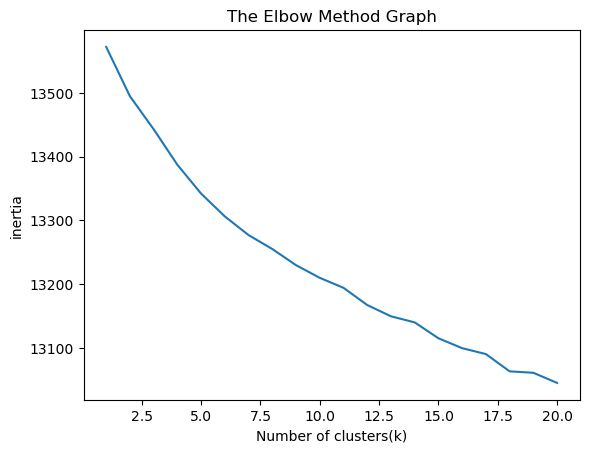

In [47]:
plt.plot(range(1,21),inertia)  
plt.title('The Elbow Method Graph')  
plt.xlabel('Number of clusters(k)')  
plt.ylabel('inertia')  
plt.show()  

In [48]:
inertia1=[]
for no in range(1000,1010):
    kmeans1=KMeans(n_clusters=no).fit(new_df)
    iner=kmeans1.inertia_
    inertia1.append(iner)

KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 


KeyboardInterrupt: 

Exception ignored in: 'sklearn.cluster._k_means_fast._relocate_empty_clusters_sparse'
Traceback (most recent call last):
  File "<__array_function__ internals>", line 2, in where
KeyboardInterrupt: 
